# Predicting titanic

Where we used a linear model for the MPG-dataset, we're going to use a logistic regression model for titanic. That's because when predicting the highway miles per gallon for a car we needed a number (26, for example, or 32 for another car). When entering the titanic what we want to know is whether or not we'll survive (yes/no) with nothing in between. Logistic regression will do that for us.

## Loading data and libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
df = pd.read_excel('files/titanic3.xlsx', engine='openpyxl')
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


There are two columns that kind of give the solution away: boat and body. Did anyone's body got found, who survived anyway?

In [3]:
# DELETE
boat_died = df[(df['body'].notnull()) & (df['survived'] == 1)]
print(boat_died[['name', 'body', 'survived']])

Empty DataFrame
Columns: [name, body, survived]
Index: []


Nope.

Show all people who were in a boat but still died.

In [4]:
# DELETE
boat_died = df[(df['boat'].notnull()) & (df['survived'] == 0)]
print(boat_died[['name', 'boat', 'survived']])

                                                   name boat  survived
19                                 Beattie, Mr. Thomson    A         0
166                            Hoyt, Mr. William Fisher   14         0
544                             Renouf, Mr. Peter Henry   12         0
655                          Backstrom, Mr. Karl Alfred    D         0
853                  Harmer, Mr. Abraham (David Lishin)    B         0
921                                   Keefe, Mr. Arthur    A         0
968                       Lindell, Mr. Edvard Bengtsson    A         0
969   Lindell, Mrs. Edvard Bengtsson (Elin Gerda Per...    A         0
1299                                Yasbeck, Mr. Antoni    C         0


Nine. Make a graph to put this in perspective: show nr of survivors vs nr of deceased for people in a boat and for people not in a boat.

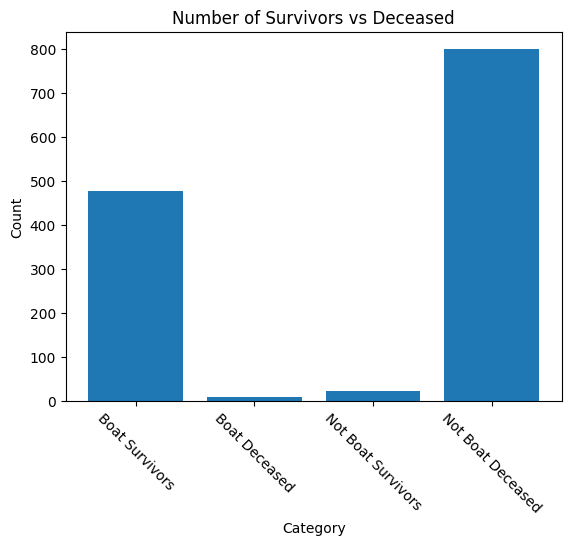

In [5]:
# DELETE

# Count the number of survivors and deceased for people in a boat
boat_survived = df[(df['boat'].notnull()) & (df['survived'] == 1)]
boat_deceased = df[(df['boat'].notnull()) & (df['survived'] == 0)]

# Count the number of survivors and deceased for people not in a boat
not_boat_survived = df[(df['boat'].isnull()) & (df['survived'] == 1)]
not_boat_deceased = df[(df['boat'].isnull()) & (df['survived'] == 0)]

# Create a bar plot
plt.bar(['Boat Survivors', 'Boat Deceased', 'Not Boat Survivors', 'Not Boat Deceased'],
        [len(boat_survived), len(boat_deceased), len(not_boat_survived), len(not_boat_deceased)])

# Add labels and title
plt.xlabel('Category')
plt.xticks(rotation=(360-45))
plt.ylabel('Count')
plt.title('Number of Survivors vs Deceased')

# Show the plot
plt.show()


To introduce a bit of a challenge, we'll drop these two columns.

In [6]:
df = df.drop(['body', 'boat'], axis=1)
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"


## Handle missing data

Running "df.isnull()" will give a dataframe with "true" for every field that is null and "false" for every other frame.

In [7]:
df.isnull()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,False,False,False,False,False,False,False,False,False,True,False,True
1305,False,False,False,False,True,False,False,False,False,True,False,True
1306,False,False,False,False,False,False,False,False,False,True,False,True
1307,False,False,False,False,False,False,False,False,False,True,False,True


If we pass this to a seaborn heatmap we get a nice visual overview of where the null-values are located in this dataset.

By the way: Seaborn is a different library for visualisations, an alternative to matplotlib. It has much nicer plots an is a bit easier to work with sometimes.

<Axes: >

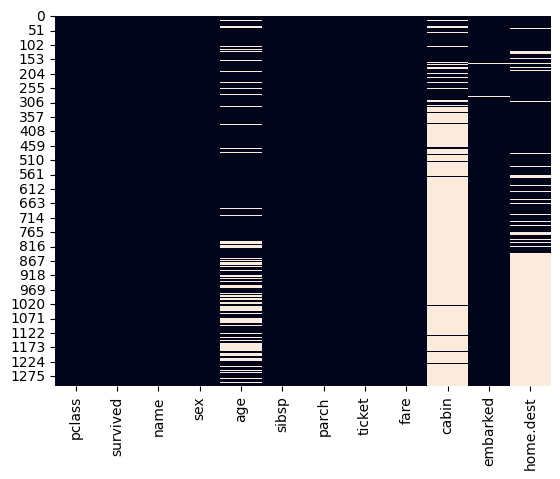

In [8]:
sns.heatmap(df.isnull(), cbar=False)

This visualisation shows that:

* Cabin is a disaster
* Home.dest is a bit better, but not much
* Age is dodgy but doable

We'll drop Cabin and home.dest as they won't be of much help predicting anything. We'll keep age as we can expect it will be a very good predictor. ("Women and children first!" or the bad guy from the titanic-movie who took some random kid with him to get on a lifeboat.)

In [9]:
df = df.drop(['cabin', 'home.dest'], axis=1)
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,S
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,S
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,S
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,S
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,S


As for age, we could fill it in, but how to do that is part of a later chapter. For now we'll simply drop the rows containing null values.

In [10]:
df.dropna(inplace = True)

## Categorical data

For this dataset we'll be building a logistic regression-model which won't work woth text-values. In the MPG-example we simply dropped these values, but in this case we'd lose the very valuable gender. To fix this, we'll be introducing dummies. A dummy will create a new column for every value in the column. For example, applying to sex that would lead to...

In [11]:
pd.get_dummies(df['sex'])

,female,male
0,True,False
1,False,True
2,True,False
3,False,True
4,True,False
...,...,...
1301,False,True
1304,True,False
1306,False,True
1307,False,True


We see two columns and every person on the boat is false in one and true in the other. (If gender was unknown they'd have false in both.) That also means they encode the same information, so it is better to drop one of them. That way alle the information is encoded in a single column. We can do this by using the "drop_first" parameter and setting it to true.

As for place of embarkment, there are 3 of them (C, Q and S). If we drop one of them the other two can't predict each other anymore.

Create 2 new dataframes based on the dummies for "sex" and "embarked". Drop the first fields and add the columns to the existing dataframe.

In [12]:
#DELETE
sex_data = pd.get_dummies(df['sex'], drop_first = True)
embarked_data = pd.get_dummies(df['embarked'], drop_first = True)
df = pd.concat([df, sex_data, embarked_data], axis = 1)

df.head()


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked,male,Q,S
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,S,False,False,True
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,S,True,False,True
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,S,False,False,True
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,S,True,False,True
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,S,False,False,True


Finally drop "sex", "embarked", "name" and "ticket" as they won't be usable (name, ticket) or needed (sex, embarked) anymore.

In [13]:
#DELETE

df.drop(['name', 'ticket', 'sex', 'embarked'], axis = 1, inplace = True)
df.head()

,pclass,survived,age,sibsp,parch,fare,male,Q,S
0,1,1,29.0000,0,0,211.3375,False,False,True
1,1,1,0.9167,1,2,151.5500,True,False,True
2,1,0,2.0000,1,2,151.5500,False,False,True
3,1,0,30.0000,1,2,151.5500,True,False,True
4,1,0,25.0000,1,2,151.5500,False,False,True


## Training and test data

Next up is splitting the data into a training set and a testing set. We'll be using the scikit-learn for this.

First is creating y_data, the dataframe with what we want to predict ("survived") and x_data (everything else).

In [14]:
#DELETE

y_data = df['survived']
x_data = df.drop('survived', axis = 1)

Next, import the train_test_split-function to split the data. Put 30% of the data in the test set.

We would also like to be able to reproduce our results. Use the ["random_state"-parameter](https://scikit-learn.org/stable/glossary.html#term-random_state) to provide an integer. Let's use 10.

In [15]:
#DELETE

from sklearn.model_selection import train_test_split

x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x_data, y_data, test_size = 0.3, random_state=10)

## Train the model

After splitting the data we'll start working on the model. Create a logistic regression model from the scikit-learn package. Fit the training data (x and y) into this model.

In [16]:
#DELETE

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=500)
model.fit(x_training_data, y_training_data)

LogisticRegression(max_iter=500)

Depending on some of the settings you may get a convergence error. [This](https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter) stackoverflow-post explains the possible causes and solutions of this very well. It boils down to not having enough data (which is true), add engineered features (the names contained a title, which we dropped now but it was actually a good predictor) or pre-process our data better (fill in the age properly). But we're still building a random forecaster, so if this happens simply increase the max_iter-parameter of the model.

Next, let the model predict whether the passengers in our x_test_data have survived. Store the results in a dataframe.

In [17]:
#DELETE

predictions = model.predict(x_test_data)

Build a confusion matrix based on these results. Use the function from the sciket-learn.

In [18]:
#DELETE

from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test_data, predictions))

[[165  34]
 [ 39  75]]


* True positives (upper left): survived and were predicted as survived
* False positives (lower left): survived but were predicted as dead
* False negatives (upper right): dead but were predicted as survived
* True positives (lower right): dead and were predicted as dead

The upper left and lower right numbers should be the highest. Our model isn't as bad as it could have been. 

Also print the classification report from the scikit-learn.

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_test_data, predictions))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       199
           1       0.69      0.66      0.67       114

    accuracy                           0.77       313
   macro avg       0.75      0.74      0.75       313
weighted avg       0.76      0.77      0.77       313



The main reason of generating this report is showing the numbers we'll be discussing in the next powerpoint.

## Predict new values

Let's predict a random person using our model.

In [20]:
random_person_dict = {
    'pclass': 1,
    'age': 35,
    'sibsp': 3, # SibSp is the number of siblings or spouse of a person onboard.
    'parch': 2, # Similar to the SibSp, this feature contained the number of parents or children each passenger was touring with.
    'fare': df.fare.mean(),
    'male': False,
    'Q': False,
    'S': False
}

random_person = pd.DataFrame(random_person_dict, index=[0])

random_person

,pclass,age,sibsp,parch,fare,male,Q,S
0,1,35,3,2,36.603024,False,False,False


Using this random person, can you have the model predict survivability?

In [21]:
model.predict(random_person)

array([1], dtype=int64)

Hooray!

Let's export this model into a pickle-file.

In [22]:
#DELETE

import pickle

with open('files/titanic_model.pkl', 'wb') as file: 
    # A new file will be created 
    pickle.dump(model, file)

# The streamlit-app

As before we'll be building a small streamlit-app to test this model. Our inputs are:

- 'pclass': 1, 2 or 3
- 'age': slider
- 'sibsp': slider
- 'parch': slider
- 'fare': options at quartiles
- 'male': gender-checkbox
- 'Q', 'S': 'place embarked'-option

Based on these you'll need to run a prediction through our (saved) model.

As for fare: fare contains outliers (one person paid a lot more that all the other people). If we'll simply make a slider based on min and max values the input will always be distorted.

An afterthought: use the [quantile function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.quantile.html) to calculate the quantiles (0.25, 0.5, 0.75 and 1(which is max)) for fare. Return them as a list.

In [28]:
list(df.fare.quantile([0.25, 0.5, 0.75, 1]))

[8.05, 15.75, 35.0771, 512.3292]